In [30]:
import os
import numpy as np
import nibabel as nib
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def load_image(file_path):
    if file_path.endswith('.nii') or file_path.endswith('.nii.gz'):
        try:
            img = nib.load(file_path)
            data = img.get_fdata()
            if data.ndim == 4 and data.shape[0] == 1:
                data = data[0]  # Remove leading singleton dimension
            return data
        except Exception as e:
            print(f"Error loading NIfTI file {file_path}: {e}")
            return None
    elif file_path.endswith('.pth'):
        try:
            data = torch.load(file_path)
            if isinstance(data, torch.Tensor):
                data = data.numpy()
            if data.ndim == 4 and data.shape[0] == 1:
                data = data[0]
            return data
        except Exception as e:
            print(f"Error loading PyTorch file {file_path}: {e}")
            return None
    else:
        print(f"Unsupported file format for: {file_path}")
        return None

def visualize_slice(original_path, ovseg_path, slice_index, overlay_style='colormap', save_path=None, dpi=500):
    data_original = load_image(original_path)
    data_ovseg = load_image(ovseg_path)

    if data_original is None or data_ovseg is None:
        print("Cannot visualize: one or both files failed to load.")
        return

    if slice_index < 0 or slice_index >= min(data_original.shape[2], data_ovseg.shape[2]):
        print(f"Invalid slice_index: {slice_index}. Must be between 0 and {min(data_original.shape[2], data_ovseg.shape[2]) - 1}")
        return

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    original_slice = data_original[:, :, slice_index]
    ovseg_slice = data_ovseg[:, :, slice_index]

    original_rotated = np.rot90(original_slice, k=3)
    ovseg_rotated = np.rot90(ovseg_slice, k=3)

    axes[0].imshow(original_rotated, cmap='gray')
    axes[0].set_title(f'Original Image (Slice {slice_index})')
    axes[0].axis('off')

    axes[1].imshow(original_rotated, cmap='gray')

    ovseg_mask = (ovseg_rotated == 0)

    if overlay_style == 'colormap':
        axes[1].imshow(np.ma.masked_where(ovseg_mask, ovseg_rotated),
                       cmap='viridis', alpha=0.5, vmin=1, vmax=9)
    elif overlay_style == 'yellow':
        colors = [(0, 0, 0, 0), (1, 1, 0, 1)]
        custom_cmap = ListedColormap(colors)
        axes[1].imshow(np.ma.masked_where(ovseg_mask, ovseg_rotated),
                       cmap=custom_cmap, alpha=0.5, vmin=0, vmax=1)
    else:
        raise ValueError("Unsupported overlay style")

    axes[1].set_title(f'Prediction Overlay (Slice {slice_index})')
    axes[1].axis('off')

    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Saved image to {save_path}")

    plt.tight_layout()
    plt.show()


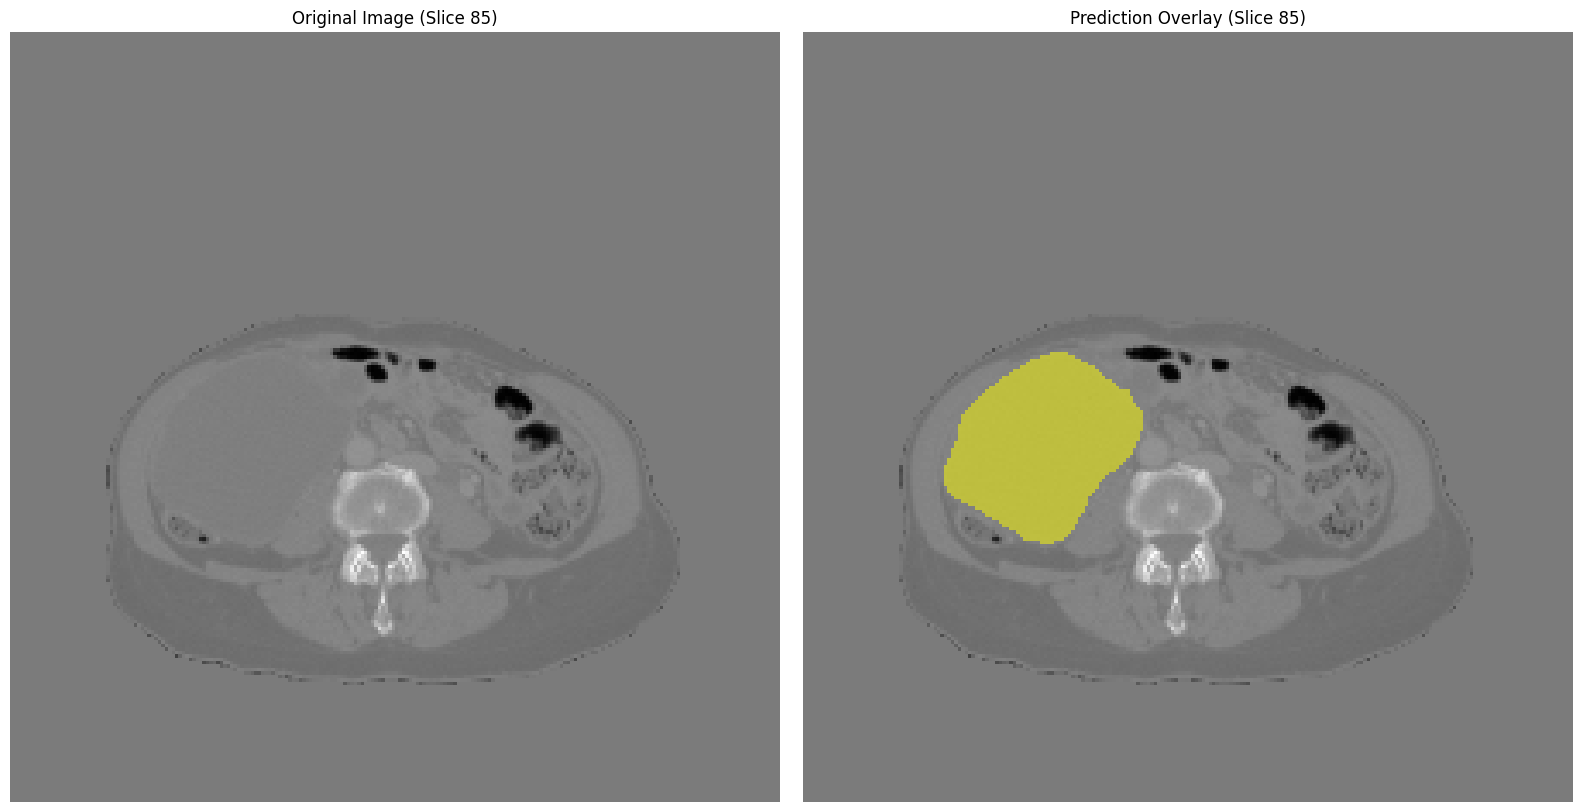

In [8]:
# Example usage
visualize_slice(
    original_path='/home/ffati/UnderXAI-OVIT/CT.nii',
    ovseg_path='/home/ffati/UnderXAI-OVIT/ovseg_predictions_pod_om/CT.nii',
    slice_index=85,
    overlay_style='yellow'  
    )

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Saved image to slice_overlay.png


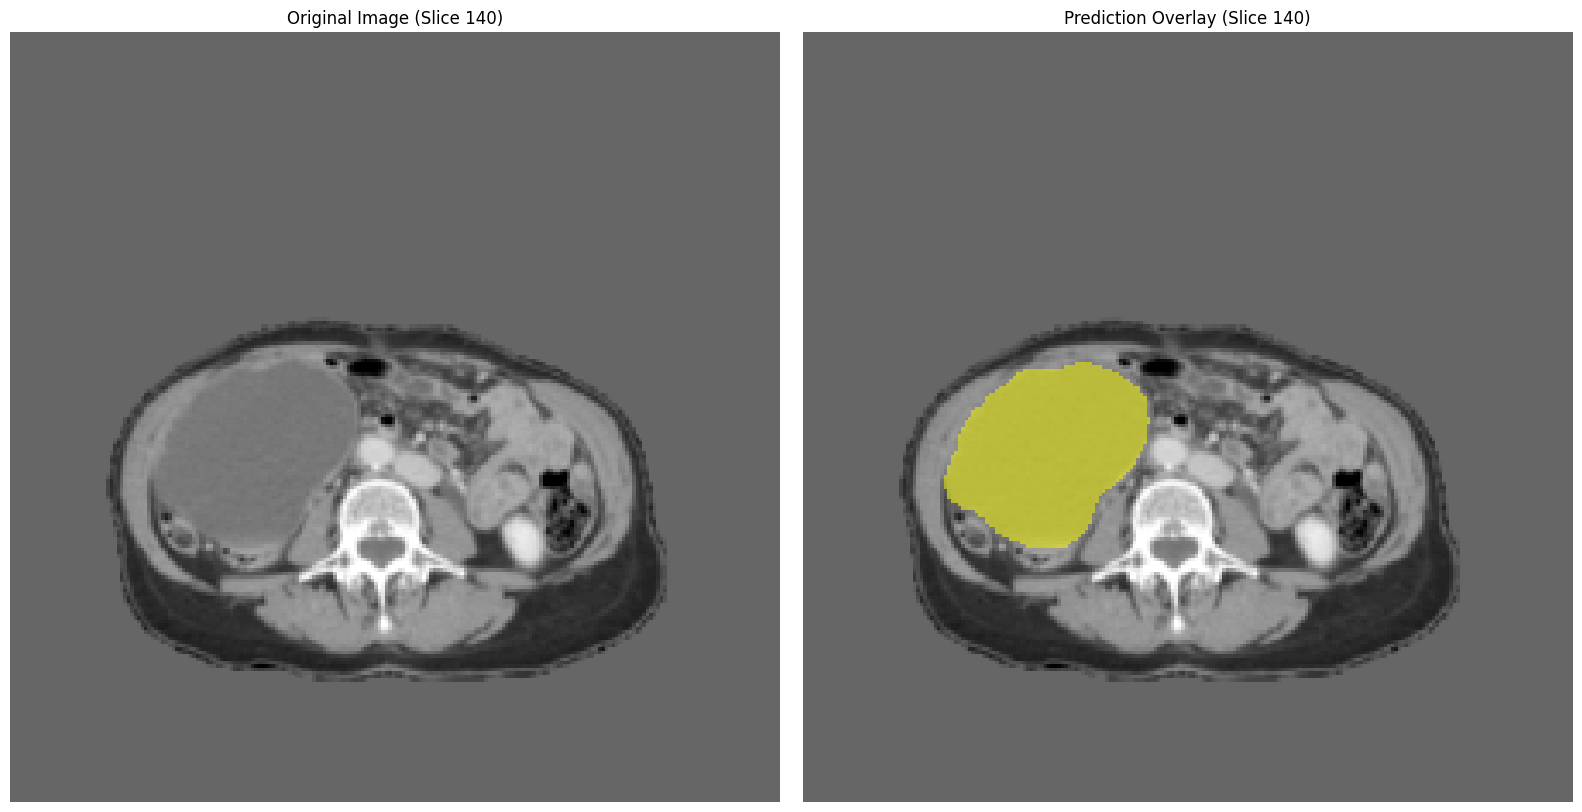

In [32]:
# Example usage
visualize_slice(
    original_path='/home/ffati/UnderXAI-OVIT/processed_data/pth/CT.pth',
    ovseg_path='/home/ffati/UnderXAI-OVIT/processed_data/pth/OC_mask.pth',
    slice_index=140,
    overlay_style='yellow',
    save_path="slice_overlay.png"
)
